# Backward propagation

## Network Architecture
![](../imgs/nn_model.png)

## 两种损失函数
**吴恩达讲解版本**
$$Loss = -\sum_{k=1}^{K}{ q(k|x)\log{p(k|x) - (1-q(k|x))(1-\log{p(k|x))}}$$
**PyTorch官方文档**
$$Loss = -\sum_{k=1}^{K}{ q(k|x)\log{p(k|x)}$$

PyTorch官方版本只关注正确分类的能力，对于不是目标类的误分类概率不考虑，吴恩达版本同时更倾向于使得每个类**误分类的概率最小**
例如，存在一个标签 $\left[ \begin{matrix} 1 \\ 0 \\ 0 \end{matrix} \right]$
给出两种预测的分布：$\left[ \begin{matrix} 0.8 \\ 0.2 \\ 0 \end{matrix} \right]$ 和 $\left[ \begin{matrix} 0.8 \\ 0.1 \\ 0.1 \end{matrix} \right]$

对于PyTorch版本，两种损失计算得到均为$-\log{0.8}$

对于吴恩达版本，第一种预测的损失为$-(\log{0.8}+\log{0.8}+\log{1})\approx 0.1938$，第二种预测的损失为$-(\log{0.8}+\log{0.9}+\log{0.9}) \approx 0.1884$

设预测正确类的概率为$p$，则在误分类概率均匀分布的时候，损失的附加项为$-\log{(1-\frac{1-p}{K-1})^{K-1}}$(对数运算加变乘)，误分类损失集中在一个类的时候，损失的附加项为$-\log{(1-(1-p))}=-\log{p}$
二者函数曲线图如下所示
![](../imgs/Wu_MultiClass_Loss.png)

数学推导：
$-\log{x}$是关于x的递减函数，只需比较x，$(1-\frac{1-p}{K-1})^{K-1}$ VS $p$
$K=2$，两项均为$p$，事实上在二分类的情况下，Wu损失函数的附加项和PyTorch交叉熵相等，所以BCE损失函数只用了一项
$(1-\frac{1-p}{K-1})^{K-1} = (\frac{K-2+p}{K-1})^{K-1}$，设$\alpha =K-1>1$，$\beta =K-2>0$
$(\frac{(\beta+p)^{\alpha}}{\alpha^{\alpha}})$ VS $p$
$(\beta+p)^{\alpha}$ VS $\alpha^{\alpha} p$
$(\beta+p)^{\alpha} < p^{\alpha} < \alpha p < \alpha^{\alpha} p \qquad p\in(0,1)$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio
import matplotlib

加载数据

In [2]:
data = scio.loadmat('ex4data1.mat')
x = data.get('X')
y = data.get('y')
x.shape, y.shape

((5000, 400), (5000, 1))

对标签进行Onehot编码

In [3]:
from NueralNetwork.Network import  onehot_encode
y_onehot, cls = onehot_encode(y)
y_onehot.shape, cls.shape

((5000, 10), (10,))

划分验证集进行验证，在验证集上的结果证明，模型及其容易过拟合

In [4]:
from sklearn.model_selection import train_test_split
# train_x, val_x, train_y, val_y = train_test_split(x, y_onehot, test_size=0.2)
train_x, val_x, train_y, val_y = x,x,y_onehot,y_onehot
for cls_idx in cls:
    train_sample_n = np.where(train_y[:,cls_idx-1]==1)[0].shape[0]
    val_sample_n = np.where(val_y[:,cls_idx-1]==1)[0].shape[0]
    print("Class {}:\t{} train samples\t{} val samples".format(cls_idx, train_sample_n, val_sample_n))
print("Total train samples: {}\n"
      "Total val samples: {}".format(train_y.shape[0],val_y.shape[0]))


Class 1:	500 train samples	500 val samples
Class 2:	500 train samples	500 val samples
Class 3:	500 train samples	500 val samples
Class 4:	500 train samples	500 val samples
Class 5:	500 train samples	500 val samples
Class 6:	500 train samples	500 val samples
Class 7:	500 train samples	500 val samples
Class 8:	500 train samples	500 val samples
Class 9:	500 train samples	500 val samples
Class 10:	500 train samples	500 val samples
Total train samples: 5000
Total val samples: 5000


加载参数

In [6]:
parameters = scio.loadmat('ex4weights.mat')
theta1 = parameters.get('Theta1').T
theta2 = parameters.get('Theta2').T
theta1.shape, theta2.shape

((401, 25), (26, 10))

使用前馈传播，查看性能

In [93]:
from BackwardPropagation import BackPropModel, regularized_loss
model_val = BackPropModel()
model_val.load_parameters([theta1, theta2])
pred_prob = model_val(val_x)

pred = np.argmax(pred_prob,axis=1) + 1
target =np.argmax(val_y, axis=1) + 1
from sklearn.metrics import classification_report
report = classification_report(pred, target, digits=4)
print(report)
loss = regularized_loss(pred_prob, val_y, [model_val.theta1, model_val.theta2], scale=1)

              precision    recall  f1-score   support

           1     0.9820    0.9684    0.9752       507
           2     0.9700    0.9818    0.9759       494
           3     0.9600    0.9776    0.9687       491
           4     0.9680    0.9699    0.9690       499
           5     0.9840    0.9723    0.9781       506
           6     0.9860    0.9782    0.9821       504
           7     0.9700    0.9778    0.9739       496
           8     0.9820    0.9781    0.9800       502
           9     0.9580    0.9657    0.9618       496
          10     0.9920    0.9822    0.9871       505

    accuracy                         0.9752      5000
   macro avg     0.9752    0.9752    0.9752      5000
weighted avg     0.9753    0.9752    0.9752      5000



进行梯度校验
$$f^{\prime}(\theta) \approx \frac{J(\theta+\epsilon) - J(\theta-\epsilon)}{2\times\epsilon}$$
对于$\theta$的每一项，单独进行$\epsilon$的加减，根据公式求其导数，随后和相对的梯队比较，随后求相对误差
$$diff = \Vert grad - grad_{approx}\Vert_2 / (\Vert gard \Vert_2 + \Vert grad_{approx} \Vert_2)$$

In [8]:
e = 1e-4
regularized = False

theta = np.concatenate((theta1.flatten(),theta2.flatten()))
theta_matrix = np.array(np.matrix(np.ones(theta.shape[0])).T @ np.matrix(theta))
epsilon_matrix = np.identity(len(theta)) * e

plus_matrix = theta_matrix + epsilon_matrix
minus_matrix = theta_matrix - epsilon_matrix
from BackwardPropagation import BackPropModel, gradient, loss
model_g = BackPropModel()
g1 = []
for i in range(len(theta)):
    theta_p1 = plus_matrix[i][:401*25].reshape(401,25)
    theta_p2 = plus_matrix[i][401*25:].reshape(26,10)
    model_g.load_parameters([theta_p1,theta_p2])
    output_g = model_g(x)
    plus_g = loss(output_g, y_onehot) / output_g.shape[0]

    theta_m1 = minus_matrix[i][:401*25].reshape(401,25)
    theta_m2 = minus_matrix[i][401*25:].reshape(26,10)
    model_g.load_parameters([theta_m1,theta_m2])
    output_g = model_g(x)
    minus_g = loss(output_g, y_onehot) / output_g.shape[0]

    g1.append((plus_g - minus_g) / (2 * e))

g1 = np.array(g1)
model = BackPropModel()
model.load_parameters([theta1, theta2])
out = model(x)

g = gradient(model, out, y_onehot)

g2 = np.concatenate((g[0].flatten(), g[1].flatten()))
diff = np.linalg.norm(g1 - g2) / (np.linalg.norm(g1) + np.linalg.norm(g2))

In [10]:
print("Gradient Check Result (Regularized: {}):\n"
      "The relative difference is {:e}, assuming epsilon is {}".format(regularized, diff, e))

Gradient Check Result (Regularized: False):
The relative difference is 2.145756e-09, assuming epsilon is 0.0001


使用Backpropagation进行训练

In [89]:
from BackwardPropagation import BackPropModel, regularized_loss, regularized_gradient
model = BackPropModel()
model.init_parameters(400, 10)
train_loss = []
val_loss = []
epochs = 1500
lr = 2
scale = 1

for epoch in range(epochs):
    output = model(train_x)
    g_1, g_2 = regularized_gradient(model, output, train_y, scale=scale)
    model.optimize([g_1, g_2],lr=lr)
    loss = regularized_loss(output, train_y, [model.theta1, model.theta2], scale=scale)
    train_loss.append(loss)
    _loss = regularized_loss(model(val_x), val_y, [model.theta1,model.theta2], scale=scale)
    val_loss.append(_loss)
    print("Epoch: {}\tTrain Loss: {:.4f}\tVal Loss: {:.4f}".format(epoch, loss, _loss))

Epoch: 0	Train Loss: 6.6658	Val Loss: 5.7531
Epoch: 1	Train Loss: 5.7525	Val Loss: 5.3290
Epoch: 2	Train Loss: 5.3300	Val Loss: 3.7822
Epoch: 3	Train Loss: 3.7818	Val Loss: 3.4132
Epoch: 4	Train Loss: 3.4135	Val Loss: 3.3025
Epoch: 5	Train Loss: 3.3024	Val Loss: 3.2606
Epoch: 6	Train Loss: 3.2607	Val Loss: 3.2481
Epoch: 7	Train Loss: 3.2481	Val Loss: 3.2387
Epoch: 8	Train Loss: 3.2388	Val Loss: 3.2302
Epoch: 9	Train Loss: 3.2302	Val Loss: 3.2208
Epoch: 10	Train Loss: 3.2208	Val Loss: 3.2101
Epoch: 11	Train Loss: 3.2101	Val Loss: 3.1974
Epoch: 12	Train Loss: 3.1974	Val Loss: 3.1821
Epoch: 13	Train Loss: 3.1821	Val Loss: 3.1636
Epoch: 14	Train Loss: 3.1636	Val Loss: 3.1414
Epoch: 15	Train Loss: 3.1414	Val Loss: 3.1149
Epoch: 16	Train Loss: 3.1150	Val Loss: 3.0841
Epoch: 17	Train Loss: 3.0841	Val Loss: 3.0488
Epoch: 18	Train Loss: 3.0489	Val Loss: 3.0097
Epoch: 19	Train Loss: 3.0098	Val Loss: 2.9674
Epoch: 20	Train Loss: 2.9676	Val Loss: 2.9227
Epoch: 21	Train Loss: 2.9229	Val Loss: 2.875

训练过程可视化

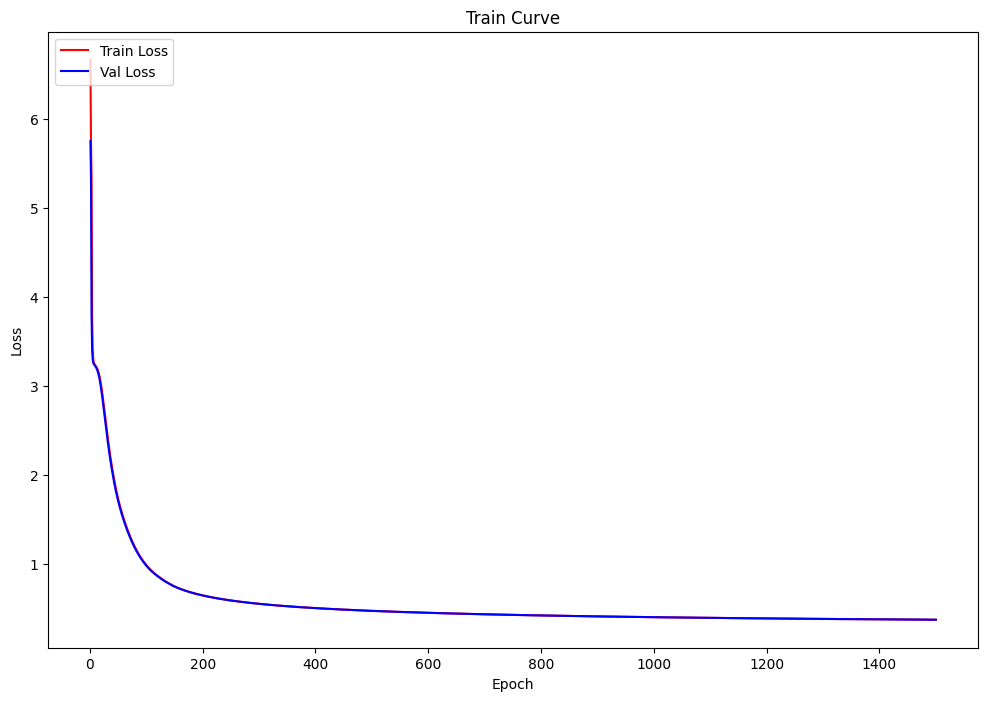

In [90]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(1,epochs+1), train_loss, 'r', label="Train Loss")
ax.plot(np.arange(1,epochs+1), val_loss, 'b', label="Val Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Train Curve')
plt.legend(loc=2)
plt.show()

查看训练后的分类性能

In [94]:
pred_prob = model(val_x)

pred = np.argmax(pred_prob,axis=1) + 1
from sklearn.metrics import classification_report
target =np.argmax(val_y, axis=1) + 1
report = classification_report(pred, target, digits=4)
print(report)

              precision    recall  f1-score   support

           1     0.9860    0.9782    0.9821       504
           2     0.9800    0.9761    0.9780       502
           3     0.9600    0.9776    0.9687       491
           4     0.9740    0.9819    0.9779       496
           5     0.9800    0.9800    0.9800       500
           6     0.9860    0.9860    0.9860       500
           7     0.9740    0.9760    0.9750       499
           8     0.9840    0.9743    0.9791       505
           9     0.9680    0.9661    0.9670       501
          10     0.9900    0.9861    0.9880       502

    accuracy                         0.9782      5000
   macro avg     0.9782    0.9782    0.9782      5000
weighted avg     0.9783    0.9782    0.9782      5000



可视化隐藏层参数

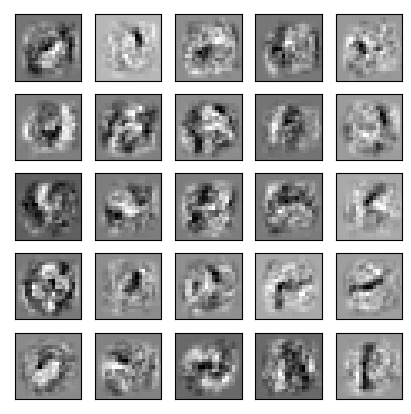

In [116]:
def plot_hidden_layer(theta):
    """
    :param theta: with shape of (401, 25)
    """
    hidden_layer = theta[1:, :]

    fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(5, 5))

    for r in range(5):
        for c in range(5):
            ax_array[r, c].matshow(hidden_layer[:,5 * r + c].reshape((20, 20)), cmap=matplotlib.cm.gray)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

plot_hidden_layer(model.theta1)